<a href="https://colab.research.google.com/github/joaopamaral/tcc_puc_cdbd/blob/master/Treinanco_Modelo_Reducing_Commercial_Aviation_Fatalities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import NearMiss

IN_COLAB = 'google.colab' in sys.modules

%matplotlib inline
plt.style.use('ggplot')

In [0]:
gdrive_kaggle_dir = '/gdrive/My Drive/Kaggle'
api_gdrive_credential_location = f'{gdrive_kaggle_dir}/kaggle.json'
data_gdrive_dir = f'{gdrive_kaggle_dir}/reducing-commercial-aviation-fatalities'
api_local_credential_location = os.path.join(os.path.expanduser('~'), '.kaggle/kaggle.json')

In [0]:
if IN_COLAB:
    if not os.path.isfile('train.csv.zip') or not os.path.isfile('test.csv.zip'):
        from google.colab import drive
        drive.mount('/gdrive')

        if os.path.isdir(gdrive_kaggle_dir):
            if os.path.isfile(f'{data_gdrive_dir}/test.csv.zip') and os.path.isfile(f'{data_gdrive_dir}/train.csv.zip'):
                !cp '{data_gdrive_dir}/train.csv.zip' .
                !cp '{data_gdrive_dir}/test.csv.zip' .
            else:
                !mkdir -p ~/.kaggle
                !cp '{api_gdrive_credential_location}' '{api_local_credential_location}'

if not os.path.isfile('train.csv.zip') or not os.path.isfile('test.csv.zip'):
    if os.path.isfile(api_local_credential_location):
        !pip -q install kaggle --upgrade
        !kaggle competitions download -c reducing-commercial-aviation-fatalities
        if IN_COLAB and os.path.isdir(gdrive_kaggle_dir):
            !cp train.csv.zip '{data_gdrive_dir}'
            !cp test.csv.zip '{data_gdrive_dir}'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
train_df = pd.read_csv('train.csv.zip').set_index(['crew', 'experiment', 'seat', 'time'])

In [0]:
eeg_columns = ['eeg_fp1', 'eeg_f7', 'eeg_f8', 'eeg_t4', 'eeg_t6', 
               'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3', 
               'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4',	'eeg_c4', 
               'eeg_p4', 'eeg_poz', 'eeg_c3', 'eeg_cz', 'eeg_o2']

numeric_features = [*eeg_columns, 'ecg', 'r', 'gsr']
categorical_features = ['event']

In [0]:
features = numeric_features
target = 'event'

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df[target], test_size=0.30, random_state=42, stratify=train_df[target])

In [0]:
print(f'Quantidade de dados de treinamento: {y_train.shape[0]}')
print(f'Quantidade de dados de teste: {X_test.shape[0]}')

Quantidade de dados de treinamento: 3407194
Quantidade de dados de teste: 1460227


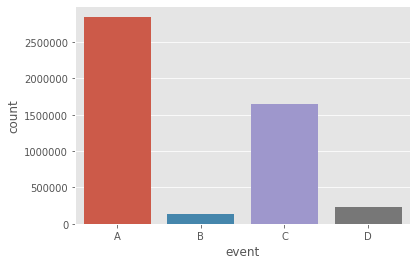

In [0]:
sns.countplot(train_df[target], order=['A', 'B', 'C', 'D']);

In [0]:
nr = NearMiss(n_jobs=-1)
balanced_X, balanced_y = nr.fit_sample(train_df[features], train_df[target])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [0]:
balanced_X = pd.DataFrame(balanced_X, columns=features)
balanced_y = pd.Series(balanced_y, name=target)

In [0]:
balanced_X_train, balanced_X_test, balanced_y_train, balanced_y_test = train_test_split(balanced_X, balanced_y, test_size=0.20, random_state=42)

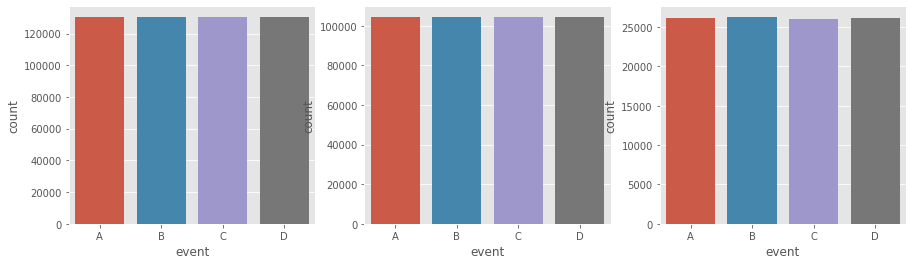

In [0]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

order = ['A', 'B', 'C', 'D']
sns.countplot(balanced_y, order=order, ax=ax[0]);
sns.countplot(balanced_y_train, order=order, ax=ax[1]);
sns.countplot(balanced_y_test, order=order, ax=ax[2]);

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        # ('cat', categorical_transformer, categorical_features)
        ])

In [0]:
from sklearn.linear_model import LogisticRegression

LR_clf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', LogisticRegression(n_jobs=-1))])

LR_clf.fit(balanced_X_train, balanced_y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

In [0]:
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, classification_report

def show_metrics(model, X_test, y_test):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, ax=ax[0])
    ax[0].set_title('Confusion matrix, without normalization')

    plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, normalize='true', ax=ax[1])
    ax[1].set_title('Normalized confusion matrix')

    plt.tight_layout()
    plt.show()

    y_predict = model.predict(X_test)

    display(pd.DataFrame(classification_report(y_test, y_predict, output_dict=True)).T)

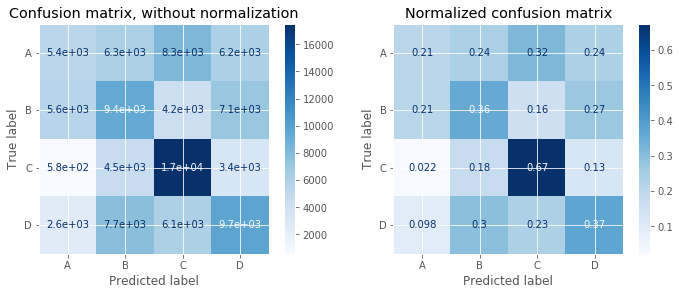

,precision,recall,f1-score,support
A,0.382414,0.206355,0.268061,26091.000000
B,0.337069,0.357890,0.347167,26307.000000
C,0.484238,0.673700,0.563469,25970.000000
D,0.368317,0.371505,0.369904,26110.000000
accuracy,0.401951,0.401951,0.401951,0.401951
macro avg,0.393009,0.402362,0.387150,104478.000000
weighted avg,0.392783,0.401951,0.386860,104478.000000


In [0]:
show_metrics(LR_clf, balanced_X_test, balanced_y_test)

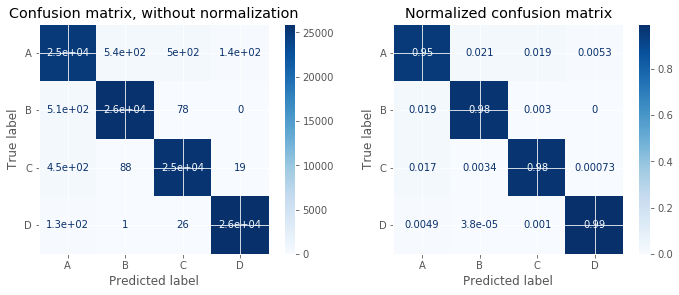

,precision,recall,f1-score,support
A,0.958005,0.954774,0.956387,26091.000000
B,0.976016,0.977649,0.976832,26307.000000
C,0.976857,0.978437,0.977646,25970.000000
D,0.993949,0.994025,0.993987,26110.000000
accuracy,0.976225,0.976225,0.976225,0.976225
macro avg,0.976207,0.976221,0.976213,104478.000000
weighted avg,0.976209,0.976225,0.976216,104478.000000


In [0]:
from sklearn.tree import DecisionTreeClassifier

DT_clf = DecisionTreeClassifier()
DT_clf.fit(balanced_X_train, balanced_y_train)

show_metrics(DT_clf, balanced_X_test, balanced_y_test)

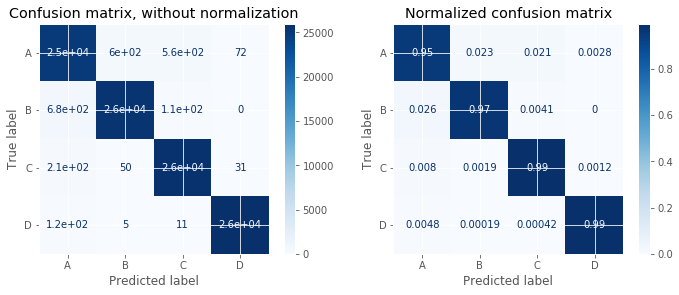

,precision,recall,f1-score,support
A,0.961000,0.952934,0.956950,26091.000000
B,0.975016,0.970198,0.972601,26307.000000
C,0.974314,0.988833,0.981520,25970.000000
D,0.996049,0.994600,0.995324,26110.000000
accuracy,0.976617,0.976617,0.976617,0.976617
macro avg,0.976595,0.976641,0.976599,104478.000000
weighted avg,0.976598,0.976617,0.976588,104478.000000


In [0]:
from sklearn.ensemble import RandomForestClassifier

RF_clf = RandomForestClassifier(n_jobs=-1)
RF_clf.fit(balanced_X_train, balanced_y_train)

show_metrics(RF_clf, balanced_X_test, balanced_y_test)

In [0]:
test_df = pd.read_csv('test.csv.zip').set_index(['crew', 'experiment', 'seat', 'time'])

In [0]:
# from sklearn.ensemble import GradientBoostingClassifier

# GB_clf = GradientBoostingClassifier()
# GB_clf.fit(balanced_X_train, balanced_y_train)

# show_metrics(GB_clf, balanced_X_test, balanced_y_test)

In [0]:
if IN_COLAB:
    !pip install -q h2o

import h2o
from h2o.automl import H2OAutoML, get_leaderboard

h2o.init()

     |████████████████████████████████| 126.2MB 108kB/s 
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.6" 2020-01-14; OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp67oaz3v_
  JVM stdout: /tmp/tmp67oaz3v_/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp67oaz3v_/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.3
H2O cluster version age:,20 days
H2O cluster name:,H2O_from_python_unknownUser_3jfm7q
H2O cluster total nodes:,1
H2O cluster free memory:,3 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


In [0]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, seed=1, max_runtime_secs=6000, max_runtime_secs_per_model=600)
aml.train(x=features, y=target, training_frame=h2o.H2OFrame(pd.concat([balanced_X_train, balanced_y_train], axis=1)))

Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |

In [0]:
lb = get_leaderboard(aml, extra_columns='ALL')
lb.head(rows=lb.nrows)